In [20]:
import networkx as nx
import pandas
import geopandas
import maup
import matplotlib.pyplot as plt
import contextily as ctx
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

from IPython.display import display

pandas.options.display.max_columns = None

In [2]:
df = geopandas.read_file("../WI-shapefiles/WI_ltsb_corrected_final.shp")
df_84 = df = df.to_crs(epsg=3857)

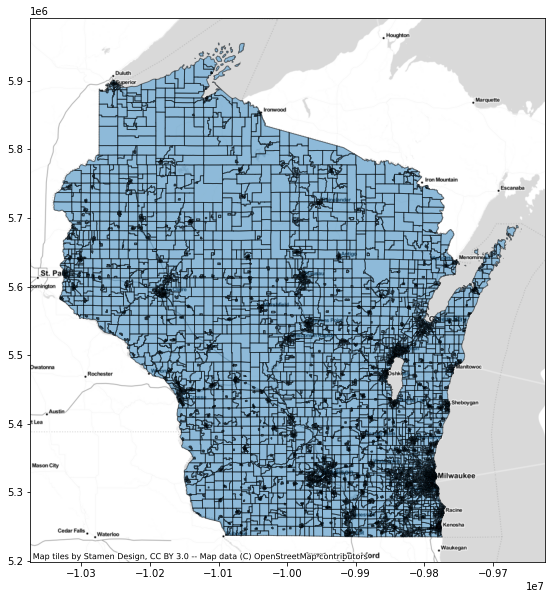

In [3]:
ax = df_84.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

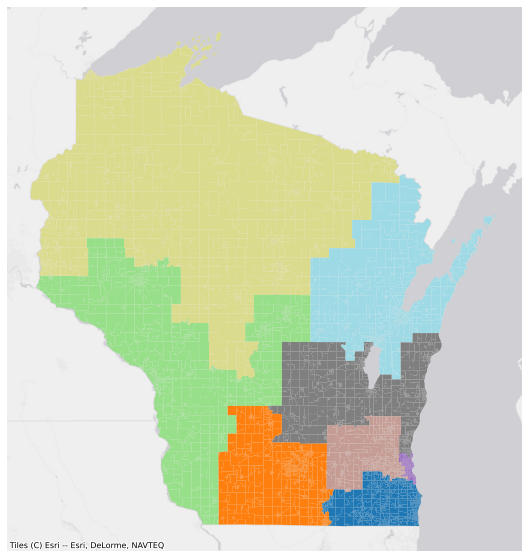

In [4]:
wi = df.plot("CON", figsize=(10,10), cmap='tab20')
wi.axis('off')
ctx.add_basemap(wi, source=ctx.providers.Esri.WorldGrayCanvas)
#plt.savefig('../../diss/classicthesis/gfx/WI-districts.pdf', bbox_inches='tight')
                #Stamen.TonerLite)

In [121]:
# df['geometry'] = df.buffer(0)

In [123]:
# graph = Graph.from_geodataframe(df)
# graph.add_data(df)

/Users/gheadley/opt/anaconda3/envs/gerry/lib/python3.8/site-packages/gerrychain/graph/graph.py:227: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1395, 63}
  warnings.warn(


In [124]:
# islands = graph.islands
# islands

{63, 1395}

In [125]:
# components = list(connected_components(graph))
# [len(c) for c in components]

[6596, 1, 36, 1]

In [126]:
# big_comp_size = max(len(c) for c in components)
# prob_comps = [c for c in components if len(c) != big_comp_size]
# for comp in prob_comps:
#     for node in comp:
#         graph.remove_node(node)

In [127]:
# is_connected(graph)

True

In [128]:
# graph.to_json('./graph-islands-deleted.json')

In [5]:
graph = Graph.from_json('./graph-islands-deleted.json')

In [12]:
nx.write_graphml(graph, 'cytoscape-output')

In [17]:
election = Election("PRES16", {"Dem":"PREDEM16", "Rep":"PREREP16"})
init_partition = Partition(
    graph,
    assignment='CON',
    updaters={
        "cut_edges": cut_edges,
        "population":Tally("PERSONS", alias='population'),
        "PRES16":election
    }
)

In [18]:
for district, pop in init_partition["population"].items():
    print("District {}: {}".format(district, pop))

District 3: 710873
District 7: 710612
District 8: 693792
District 6: 710873
District 2: 710874
District 5: 710873
District 1: 710874
District 4: 710873


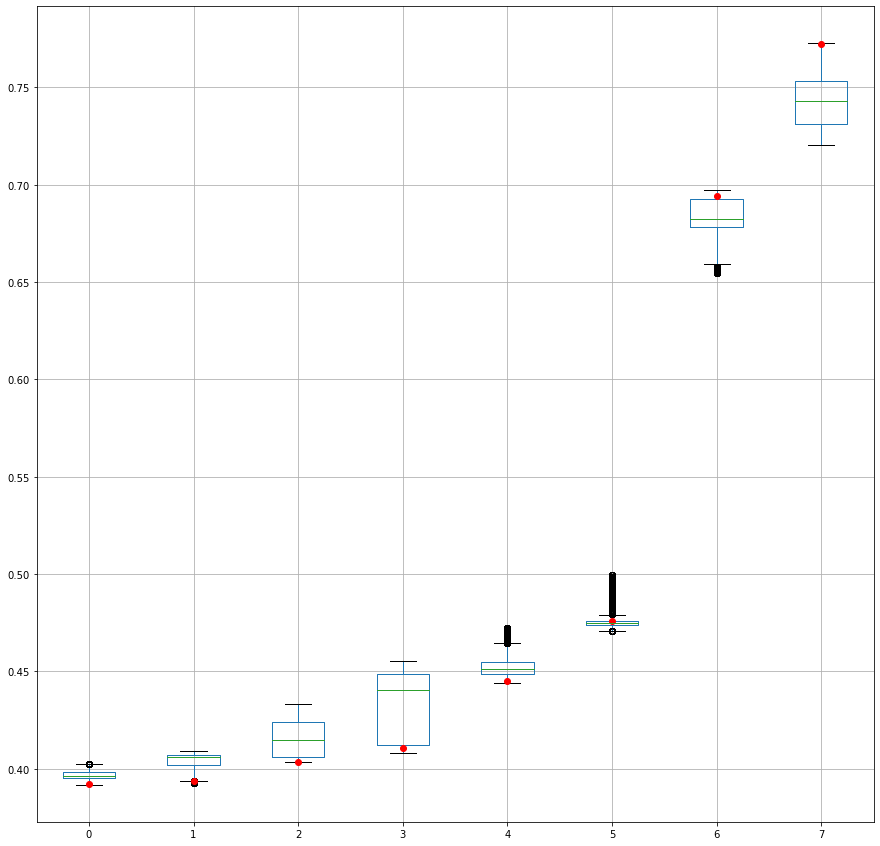

In [37]:
data = None

chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=init_partition,
    total_steps=10000
)

dem_percents = [sorted(partition["PRES16"].percents("Dem")) for partition in chain]
data = pandas.DataFrame(dem_percents)
ax = data.boxplot(positions=range(len(data.columns)), figsize=(15,15))
plt.plot(data.iloc[0], "ro")
plt.show()
